# Exercise 3

In [19]:
# Notes-faithful NTRU (Implementation 4, fixed)
from sage.all import *
import random
import time

class NTRU_Notes:
    """
    Notes-faithful NTRU:
      - Ring: R_q = Z_q[x]/(x^N - 1), R_p = Z_p[x]/(x^N - 1)
      - f = 1 + F with F ternary (df+1 ones, df minus ones)
      - g, r, m are ternary with same weights
      - public h = g * f^{-1} (mod q)
      - encryption: c = m + p * r * h (mod q)
      - decryption: a = f * c (mod q) -> center lift -> reduce mod p -> multiply by f^{-1} (mod p)
    """

    def __init__(self, N, q, p=3, df=None):
        self.N = int(N)
        self.q = int(q)
        self.p = int(p)
        self.df = df if df is not None else self.N // 3

        # Polynomial quotient rings
        self.Rq = PolynomialRing(Integers(self.q), 'x')
        self.RqQ = self.Rq.quotient(self.Rq.gen()**self.N - 1, 'x')
        self.Rp = PolynomialRing(Integers(self.p), 'x')
        self.RpQ = self.Rp.quotient(self.Rp.gen()**self.N - 1, 'x')

    # -----------------------
    # Small ternary polynomials
    # -----------------------
    def random_ternary_poly(self, plus, minus, ring='Rq'):
        """
        Construct a polynomial with exactly `plus` coefficients = +1,
        `minus` coefficients = -1 and rest 0. Return in the chosen quotient ring.
        ring: 'Rq' (default) or 'Rp'
        """
        coeffs = [1]*plus + [-1]*minus + [0]*(self.N - plus - minus)
        random.shuffle(coeffs)
        if ring == 'Rq':
            return self.RqQ(coeffs)
        else:
            return self.RpQ(coeffs)

    # -----------------------
    # Message sampling in R_p
    # -----------------------
    def random_message_poly(self):
        """
        Sample message m in R_p: exactly df+1 ones and df minus ones (ternary),
        then return as an element of R_p (RpQ).
        This follows the notes' choice for m.
        """
        # Use same sparsity as notes: df+1 ones, df minus ones
        coeffs = [1]*(self.df+1) + [-1]*self.df + [0]*(self.N - (2*self.df + 1))
        random.shuffle(coeffs)
        return self.RpQ(coeffs)

    # -----------------------
    # Center lift
    # -----------------------
    def center_lift(self, poly, mod):
        """
        Return a list of integer coefficients in the centered interval [-mod//2, mod//2]
        poly may be in RqQ or RpQ or a plain polynomial; we use .lift().list()
        """
        coeffs = poly.lift().list()
        coeffs += [0] * (self.N - len(coeffs))
        centered = []
        for c in coeffs:
            ci = int(c) % mod
            if ci > mod // 2:
                ci -= mod
            centered.append(ci)
        return centered

    # -----------------------
    # Key generation
    # -----------------------
    def keygen(self, max_attempts=200):
        """
        Generate (public, private) per notes:
          f = 1 + F (F ternary with df+1 and df)
          g ternary
        Ensure f invertible mod q and mod p.
        Returns dict: { "public": h, "private": (f, f_inv_p) }
        """
        g = self.random_ternary_poly(self.df+1, self.df, ring='Rq')

        attempt = 0
        while True:
            attempt += 1
            F = self.random_ternary_poly(self.df+1, self.df, ring='Rq')
            f = self.RqQ(1) + F  # f = 1 + F

            try:
                # inverse of f in R_q
                f_inv_q = f.inverse_of_unit()
                # build representative of f modulo p and invert in R_p
                f_center_q = self.center_lift(f, self.q)     # list ints centered mod q
                f_mod_p = self.RpQ([x % self.p for x in f_center_q])
                f_inv_p = f_mod_p.inverse_of_unit()  # may raise if not invertible
                break
            except (ArithmeticError, ZeroDivisionError):
                if attempt >= max_attempts:
                    raise RuntimeError("Failed to generate invertible f after many attempts")
                continue

        # public key per notes: h = g * f^{-1} (in R_q)
        h = g * f_inv_q
        h = self.RqQ([int(x) % self.q for x in h.lift().list()])  # normalize coefficients
        return {"public": h, "private": (f, f_inv_p)}

    # -----------------------
    # Encrypt: accept m in R_p, lift to R_q
    # -----------------------
    def encrypt(self, h, m_p):
        """
        m_p: an RpQ element (message in R_p)
        returns: ciphertext polynomial in R_q (RqQ)
        """
        # lift message to R_q
        m_q = self.RqQ(m_p.lift().list())
        r = self.random_ternary_poly(self.df, self.df, ring='Rq')
        c = m_q + self.p * r * h
        # normalize to RqQ
        return self.RqQ([int(x) % self.q for x in c.lift().list()])

    # -----------------------
    # Decrypt: returns message coefficients as list centered mod p
    # -----------------------
    def decrypt(self, c, priv):
        """
        c: RqQ ciphertext
        priv: (f, f_inv_p) where f in RqQ and f_inv_p in RpQ
        Returns: list of ints = coefficients of recovered m in [-p//2, p//2]
        """
        f, f_inv_p = priv
        a = f * c
        # center-lift modulo q to integers
        a_centered = self.center_lift(a, self.q)
        # reduce modulo p to form element in RpQ
        a_mod_p = self.RpQ([x % self.p for x in a_centered])
        m_rec = a_mod_p * f_inv_p
        # return centered representative mod p
        return self.center_lift(m_rec, self.p)


In [22]:
# -----------------------
# LLL attack (notes version)
# -----------------------
def LLL_attack_notes(ntru, h, delta=0.99, scan_rows=50):
    """
    Build B = [I | T_h; 0 | q I] and run LLL(delta).
    Scan first `scan_rows` rows of reduced basis for small f candidate (ternary).
    Returns recovered (f_q, f_inv_p) or None.
    """
    N, q = ntru.N, ntru.q

    # get h coefficients and build circulant T_h
    h_coeffs = h.lift().list()
    h_coeffs += [0] * (N - len(h_coeffs))
    rows = [h_coeffs[-i:] + h_coeffs[:-i] for i in range(N)]
    T_h = matrix(ZZ, rows)

    I = identity_matrix(ZZ, N)
    Z = zero_matrix(ZZ, N)
    qI = q * I
    B = block_matrix([[I, T_h], [Z, qI]])

    # LLL reduction
    B_red = B.LLL(delta=delta)

    # Scan rows
    for i, row in enumerate(B_red.rows()[:scan_rows]):
        f_vec = list(row[:N])
        # heuristic: small coefficients (ternary-ish)
        if all(abs(x) <= 2 for x in f_vec):
            try:
                f_q = ntru.RqQ([int(x) % q for x in f_vec])
                # build f modulo p for invert test
                f_p = ntru.RpQ([int(x) % ntru.p for x in f_vec])
                f_inv_p = f_p.inverse_of_unit()
                return (f_q, f_inv_p)
            except Exception:
                continue
    return None


# -----------------------
# Correctness test (fixed)
# -----------------------
def test_ntru_correctness_fixed(N=11, q=127, p=3, df=None, trials=20, verbose=True):
    ntru = NTRU_Notes(N=N, q=q, p=p, df=df)
    for i in range(trials):
        keys = ntru.keygen()
        # message in R_p
        m_p = ntru.random_message_poly()
        m_target = ntru.center_lift(m_p, p)  # list of ints in [-p//2, p//2]

        c = ntru.encrypt(keys["public"], m_p)
        m_rec = ntru.decrypt(c, keys["private"])

        if m_rec != m_target:
            if verbose:
                print(f"❌ Failure at trial {i}")
                print("m     =", m_target)
                print("m_rec =", m_rec)
            return False

    if verbose:
        print(f"✅ NTRU correctness test passed ({trials}/{trials})")
    return True


# -----------------------
# LLL sanity test (fixed)
# -----------------------
def test_lll_attack_small_fixed(N=11, q=61, p=3, df=None, delta=0.99, trials=10):
    print("=== LLL SANITY TEST ===")
    print(f"N={int(N)}, q={int(q)}, p={int(p)}, df={int(df or N//3)}, delta={float(delta)}")
    print("-" * 40)

    success = 0

    for i in range(int(trials)):
        ntru = NTRU_Notes(N=int(N), q=int(q), p=int(p), df=df)
        keys = ntru.keygen()

        m_p = ntru.random_message_poly()
        m_target = ntru.center_lift(m_p, p)
        c = ntru.encrypt(keys["public"], m_p)

        start = time.time()
        recovered = LLL_attack_notes(ntru, keys["public"], delta=float(delta))
        elapsed = time.time() - start

        ok = False
        if recovered:
            try:
                m_rec = ntru.decrypt(c, recovered)
                ok = (m_rec == m_target)
            except Exception:
                ok = False

        if ok:
            success += 1
            status = "✓ SUCCESS"
        else:
            status = "✗ fail"

        print(f"Trial {i+1:2d}: {status}   ({elapsed:.4f}s)")

    print("-" * 40)
    rate = float(success) / float(trials)
    print(f"Success rate: {success}/{trials} = {rate:.2%}")
    return success, trials



In [23]:
# 1) Check basic correctness
test_ntru_correctness_fixed(N=11, q=127, trials=10)

# 2) Sanity-check LLL on intentionally weak parameters
test_lll_attack_small_fixed(N=11, q=31, delta=0.99, trials=6)

# 3) If sanity passed, then run your parameter sweeps (CSV generator I gave earlier)


✅ NTRU correctness test passed (10/10)
=== LLL SANITY TEST ===
N=11, q=31, p=3, df=3, delta=0.99
----------------------------------------
Trial  1: ✓ SUCCESS   (0.0043s)
Trial  2: ✓ SUCCESS   (0.0020s)
Trial  3: ✓ SUCCESS   (0.0020s)
Trial  4: ✓ SUCCESS   (0.0024s)
Trial  5: ✓ SUCCESS   (0.0025s)
Trial  6: ✓ SUCCESS   (0.0020s)
----------------------------------------
Success rate: 6/6 = 100.00%


(6, 6)

In [24]:
from multiprocessing import Pool, cpu_count
import pandas as pd

def experiment_worker(args):
    """
    Worker for a single (N, q, p, df, delta, trials) configuration.
    Returns a dict of plain Python values.
    """
    N, q, p, df, delta, trials = args

    successes = 0
    total_time = 0.0

    for _ in range(int(trials)):
        ntru = NTRU_Notes(N=int(N), q=int(q), p=int(p), df=int(df))
        keys = ntru.keygen()

        m_p = ntru.random_message_poly()
        m_target = ntru.center_lift(m_p, p)
        c = ntru.encrypt(keys["public"], m_p)

        start = time.time()
        recovered = LLL_attack_notes(ntru, keys["public"], delta=float(delta))
        elapsed = time.time() - start
        total_time += elapsed

        if recovered:
            try:
                m_rec = ntru.decrypt(c, recovered)
                if m_rec == m_target:
                    successes += 1
            except Exception:
                pass

    return {
        "N": int(N),
        "q": int(q),
        "p": int(p),
        "df": int(df),
        "delta": float(delta),
        "trials": int(trials),
        "successes": int(successes),
        "success_rate": float(successes) / float(trials),
        "avg_attack_time": float(total_time) / float(trials),
    }


In [25]:
def run_experiments_parallel(
    N_list,
    q_list,
    delta_list,
    trials,
    p=3,
    df_rule=lambda N: N // 3,
    n_jobs=None
):
    """
    Run NTRU–LLL experiments in parallel and return a pandas DataFrame.
    """
    if n_jobs is None:
        n_jobs = max(1, cpu_count() - 1)

    # Build parameter grid
    param_grid = []
    for N in N_list:
        for q in q_list:
            for delta in delta_list:
                param_grid.append((
                    int(N),
                    int(q),
                    int(p),
                    int(df_rule(N)),
                    float(delta),
                    int(trials),
                ))

    print(f"Running {len(param_grid)} experiments on {n_jobs} processes")

    with Pool(processes=n_jobs) as pool:
        results = pool.map(experiment_worker, param_grid)

    # Convert to pandas DataFrame
    df = pd.DataFrame(results)

    return df


In [27]:
def summarize_results(df):
    print("\n=== EXPERIMENT SUMMARY ===\n")

    print("Overall:")
    print(df.describe())

    print("\nGrouped by (N, delta):")
    summary = (
        df.groupby(["N", "delta"])
          .agg({
              "success_rate": ["mean", "std"],
              "avg_attack_time": ["mean", "std"]
          })
    )
    print(summary)

    return summary

def save_results(df, filename="ntru_lll_results.csv"):
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")


In [32]:
# Weak → moderate parameters (for visible transitions)
N_list = [19, 31, 53, 59, 83, 97, 107, 131, 167]
q_list = [31, 63, 127, 257, 2047]
delta_list = [0.75, 0.85, 0.90, 0.95, 0.99]
trials = 10

df_results = run_experiments_parallel(
    N_list=N_list,
    q_list=q_list,
    delta_list=delta_list,
    trials=trials
)

summary = summarize_results(df_results)

save_results(df_results)

Running 250 experiments on 11 processes

=== EXPERIMENT SUMMARY ===

Overall:
                N            q      p          df      delta  trials  \
count  250.000000   250.000000  250.0  250.000000  250.00000   250.0   
mean    76.200000   505.000000    3.0   24.800000    0.88800    10.0   
std     47.670219   776.434028    0.0   15.873496    0.08369     0.0   
min     11.000000    31.000000    3.0    3.000000    0.75000    10.0   
25%     31.000000    63.000000    3.0   10.000000    0.85000    10.0   
50%     71.000000   127.000000    3.0   23.000000    0.90000    10.0   
75%    107.000000   257.000000    3.0   35.000000    0.95000    10.0   
max    167.000000  2047.000000    3.0   55.000000    0.99000    10.0   

        successes  success_rate  avg_attack_time  
count  250.000000    250.000000       250.000000  
mean     2.964000      0.296400         3.198615  
std      4.461651      0.446165        11.665972  
min      0.000000      0.000000         0.002741  
25%      0.000000 

In [33]:
print(df_results.head())

    N   q  p  df  delta  trials  successes  success_rate  avg_attack_time
0  11  31  3   3   0.75      10          8           0.8         0.007290
1  11  31  3   3   0.85      10          8           0.8         0.002987
2  11  31  3   3   0.90      10          8           0.8         0.003038
3  11  31  3   3   0.95      10          9           0.9         0.002995
4  11  31  3   3   0.99      10          9           0.9         0.003031


In [38]:
from sage.all import *
import time
import random
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm  # Use tqdm.notebook for nicer Jupyter output

# -------------------------------------------------------
# 1. Modified LLL Attack to return Norms (Fixed Types)
# -------------------------------------------------------
def LLL_attack_with_stats(ntru, h, delta=0.99, scan_rows=50):
    """
    Returns: (recovered_key, shortest_vector_norm)
    - recovered_key: The (f_q, f_inv_p) tuple if found, else None
    - shortest_vector_norm: The Euclidean norm of the first vector in the reduced basis
    """
    N, q = ntru.N, ntru.q

    # Build Lattice Basis
    h_coeffs = h.lift().list()
    h_coeffs += [0] * (N - len(h_coeffs))
    
    # Ensure matrix is built over ZZ (Integers)
    rows = [h_coeffs[-i:] + h_coeffs[:-i] for i in range(N)]
    T_h = matrix(ZZ, rows)

    I = identity_matrix(ZZ, N)
    Z = zero_matrix(ZZ, N)
    qI = q * I
    B = block_matrix([[I, T_h], [Z, qI]])

    # Run LLL
    B_red = B.LLL(delta=delta)

    # Metric: Capture the norm of the shortest vector found (Row 0)
    # FIX: Convert Sage Integers to Python ints to avoid type issues with numpy
    shortest_vec_sage = list(B_red[0][:N])
    shortest_vec = [int(x) for x in shortest_vec_sage]
    shortest_norm = float(np.linalg.norm(shortest_vec))

    # Search for the key in the top rows
    recovered_key = None
    for i, row in enumerate(B_red.rows()[:scan_rows]):
        f_vec = list(row[:N])
        # Heuristic check: coeffs should be small (ternary-ish)
        if all(abs(x) <= 2 for x in f_vec): 
            try:
                f_q = ntru.RqQ([int(x) % q for x in f_vec])
                f_p = ntru.RpQ([int(x) % ntru.p for x in f_vec])
                f_inv_p = f_p.inverse_of_unit()
                recovered_key = (f_q, f_inv_p)
                break
            except Exception:
                continue

    return recovered_key, shortest_norm

# -------------------------------------------------------
# 2. Updated Worker to calculate Norm Ratio (Fixed Types)
# -------------------------------------------------------
def experiment_worker_advanced(args):
    N, q, p, df, delta, trials = args

    successes = 0
    total_time = 0.0
    total_norm_ratio = 0.0
    valid_ratios = 0

    for _ in range(int(trials)):
        ntru = NTRU_Notes(N=int(N), q=int(q), p=int(p), df=int(df))
        keys = ntru.keygen()

        # 1. Calculate Target Norm (Expected Shortest Vector)
        f_poly = keys["private"][0]
        
        # CRITICAL FIX: Convert Sage IntegerMod coefficients to Python ints.
        # Otherwise, numpy tries to do modular arithmetic for the norm.
        f_coeffs_mod = f_poly.lift().list()
        f_vec = [int(x) for x in f_coeffs_mod]
        
        # Pad with zeros to match dimension N
        f_vec += [0] * (N - len(f_vec))
        
        # Now it is safe to compute Euclidean norm
        target_norm = float(np.linalg.norm(f_vec))

        # Standard encryption setup
        m_p = ntru.random_message_poly()
        m_target = ntru.center_lift(m_p, p)
        c = ntru.encrypt(keys["public"], m_p)

        # Attack
        start = time.time()
        # USE THE NEW ATTACK FUNCTION
        recovered, found_norm = LLL_attack_with_stats(ntru, keys["public"], delta=float(delta))
        elapsed = time.time() - start
        total_time += elapsed

        # Calculate Ratio: (Found Shortest Norm) / (Actual Key Norm)
        if target_norm > 0:
            ratio = found_norm / target_norm
            total_norm_ratio += ratio
            valid_ratios += 1

        # Check success
        if recovered:
            try:
                m_rec = ntru.decrypt(c, recovered)
                if m_rec == m_target:
                    successes += 1
            except Exception:
                pass

    avg_ratio = (total_norm_ratio / valid_ratios) if valid_ratios > 0 else -1.0

    return {
        "N": int(N),
        "q": int(q),
        "delta": float(delta),
        "success_rate": float(successes) / float(trials),
        "avg_attack_time": float(total_time) / float(trials),
        "avg_norm_ratio": avg_ratio
    }

# -------------------------------------------------------
# 3. Parallel Runner with TQDM Progress Bar
# -------------------------------------------------------
def run_experiments_with_progress(N_list, q_list, delta_list, trials, n_jobs=None):
    if n_jobs is None:
        n_jobs = max(1, cpu_count() - 1)

    # 1. Build Parameter Grid
    param_grid = []
    p = 3
    for N in N_list:
        df = N // 3 # Standard ternary parameter
        for q in q_list:
            for delta in delta_list:
                param_grid.append((N, q, p, df, delta, trials))

    print(f"Queueing {len(param_grid)} tasks on {n_jobs} cores...")

    # 2. Run with Progress Bar
    results = []
    with Pool(processes=n_jobs) as pool:
        # imap_unordered yields results as soon as they finish
        worker_iterator = pool.imap_unordered(experiment_worker_advanced, param_grid)

        # Wrap the iterator with tqdm for the progress bar
        # 'total' is required because imap doesn't expose length
        for result in tqdm(worker_iterator, total=len(param_grid), desc="Attacking Lattices"):
            results.append(result)

    return pd.DataFrame(results)

# -------------------------------------------------------
# 4. Execute the New Test
# -------------------------------------------------------
# Define your search space
N_range = [19, 41, 61, 83, 107, 131, 167]
q_range = [31, 63, 127, 257, 2047] 
delta_vals = [0.75, 0.85, 0.99]      

# Run
df_results_new = run_experiments_with_progress(
    N_list=N_range,
    q_list=q_range,
    delta_list=delta_vals,
    trials=5  # Adjust trials based on how much time you have
)

# Sort and display
df_results_new = df_results_new.sort_values(by=['N', 'q'])
print("Results sample:")
display(df_results_new.head())

Queueing 105 tasks on 11 cores...


Attacking Lattices:   0%|          | 0/105 [00:00<?, ?it/s]

Results sample:


,N,q,delta,success_rate,avg_attack_time,avg_norm_ratio
3,19,31,0.99,0.0,0.016679,0.0511131516248580
4,19,31,0.85,0.0,0.015073,0.0518683522052232
7,19,31,0.75,0.0,0.014641,0.0723984682329129
9,19,63,0.99,1.0,0.007731,0.0254527790866237
10,19,63,0.85,1.0,0.009346,0.0251826888958144


In [41]:
df_results_new.to_csv('ntru_lll_attack_results.csv', index=False)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# 1. Load Data Fresh from CSV
# We read directly from the file to avoid any in-memory corruption or type issues from previous cells
csv_path = 'ntru_lll_attack_results.csv'
try:
    df = pd.read_csv(csv_path)
    print(f"Successfully loaded {len(df)} rows from {csv_path}")
except FileNotFoundError:
    print(f"Error: {csv_path} not found. Please ensure the file is in the same directory.")
    # Create dummy data for demonstration if file is missing
    df = pd.DataFrame({
        'N': [20, 20, 40, 40, 60, 60],
        'q': [31, 31, 31, 31, 31, 31],
        'success_rate': [1.0, 0.9, 0.5, 0.4, 0.1, 0.0],
        'avg_norm_ratio': [0.05, 0.06, 0.02, 0.03, 0.01, 0.01]
    })

# 2. Clean and Convert Data
# Ensure all columns are standard numeric types (float/int), not Objects
cols_to_fix = ['N', 'q', 'success_rate', 'avg_norm_ratio']
for col in cols_to_fix:
    if col in df.columns:
        # force conversion, turn non-parseable values into NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with NaNs in critical columns
df_clean = df.dropna(subset=cols_to_fix).copy()

print(f"Data after cleaning: {len(df_clean)} rows")
print(df_clean.dtypes)

if df_clean.empty:
    print("WARNING: DataFrame is empty after cleaning! Check your CSV data format.")
else:
    print("Data looks good. Proceeding to plot.")

Successfully loaded 105 rows from ntru_lll_attack_results.csv
Data after cleaning: 105 rows
N                    int64
q                    int64
delta              float64
success_rate       float64
avg_attack_time    float64
avg_norm_ratio     float64
dtype: object
Data looks good. Proceeding to plot.


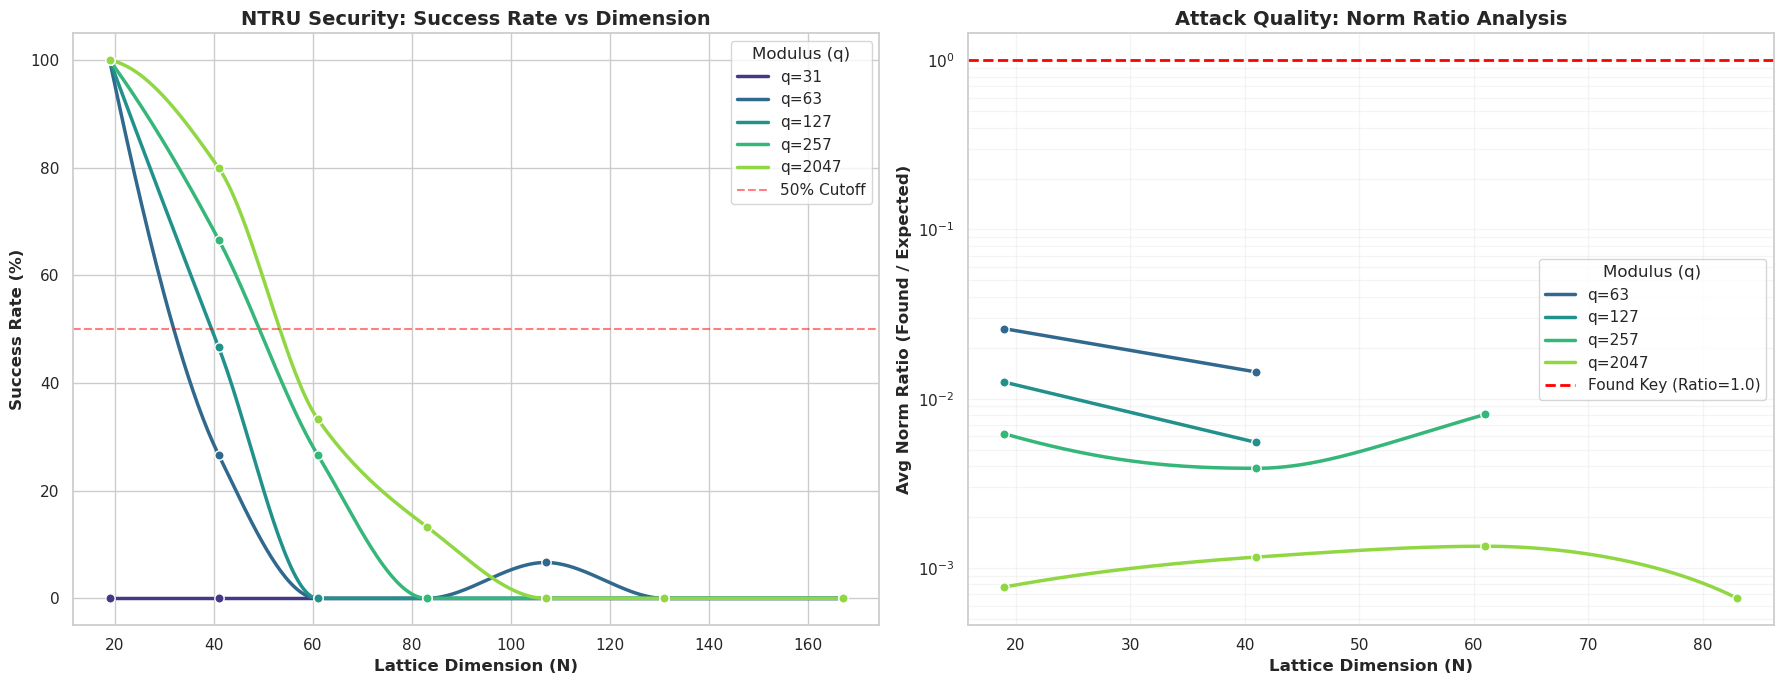

In [48]:
# Setup Plot
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

unique_qs = sorted(df_clean['q'].unique())
palette = sns.color_palette("viridis", len(unique_qs))

from scipy.interpolate import PchipInterpolator

def get_smooth_curve(x, y, num_points=300):
    """Generates a smooth curve using PCHIP interpolation (monotonic)."""
    if len(x) < 2:
        return x, y
    
    # Sort by x for interpolation
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    x_new = np.linspace(x_sorted.min(), x_sorted.max(), num_points)
    try:
        interpolator = PchipInterpolator(x_sorted, y_sorted)
        y_new = interpolator(x_new)
        return x_new, y_new
    except Exception as e:
        return x, y

# Plotting Loop
for color, q_val in zip(palette, unique_qs):
    subset = df_clean[df_clean['q'] == q_val]
    
    # Aggregate: Take mean for each N
    agg_subset = subset.groupby('N')[['success_rate', 'avg_norm_ratio']].mean().reset_index()
    agg_subset = agg_subset.sort_values('N')
    
    if agg_subset.empty:
        continue

    # --- Plot 1: Success Rate (Include all data) ---
    x = agg_subset['N'].values
    y = agg_subset['success_rate'].values * 100
    
    xs, ys = get_smooth_curve(x, y)
    ys = np.clip(ys, 0, 100) 
    
    ax1.plot(xs, ys, color=color, linewidth=2.5, label=f"q={q_val}")
    ax1.scatter(x, y, color=color, s=45, edgecolor="white", zorder=3)

    # --- Plot 2: Norm Ratio (Exclude failed attacks) ---
    # Filter out points where success rate is 0 or ratio is effectively 0
    # This prevents the "dive to zero" artifact on the log plot
    valid_mask = (agg_subset['success_rate'] > 0) & (agg_subset['avg_norm_ratio'] > 1e-6)
    
    if valid_mask.sum() > 0:
        x_norm = agg_subset.loc[valid_mask, 'N'].values
        y_norm = agg_subset.loc[valid_mask, 'avg_norm_ratio'].values
        
        # Only smooth if we have enough points, otherwise just plot connected lines
        if len(x_norm) > 2:
            xs_norm, ys_norm = get_smooth_curve(x_norm, y_norm)
            ax2.plot(xs_norm, ys_norm, color=color, linewidth=2.5, label=f"q={q_val}")
        else:
            ax2.plot(x_norm, y_norm, color=color, linewidth=2.5, label=f"q={q_val}")
            
        ax2.scatter(x_norm, y_norm, color=color, s=45, edgecolor="white", zorder=3)

# Formatting Ax1
ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% Cutoff')
ax1.set_title("NTRU Security: Success Rate vs Dimension", fontsize=14, fontweight='bold')
ax1.set_xlabel("Lattice Dimension (N)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Success Rate (%)", fontsize=12, fontweight='bold')
ax1.legend(title="Modulus (q)")
ax1.set_ylim(-5, 105)

# Formatting Ax2
ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Found Key (Ratio=1.0)')
ax2.set_title("Attack Quality: Norm Ratio Analysis", fontsize=14, fontweight='bold')
ax2.set_xlabel("Lattice Dimension (N)", fontsize=12, fontweight='bold')
ax2.set_ylabel("Avg Norm Ratio (Found / Expected)", fontsize=12, fontweight='bold')
ax2.legend(title="Modulus (q)")
ax2.set_yscale('log')
ax2.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()